In [33]:
import numpy as np
import pandas as pd
import spacy
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
import re
from fractions import Fraction
import time


# Create the dataframes

In [34]:
df_train = pd.read_csv('home_depot_data/train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('home_depot_data/test.csv', encoding="ISO-8859-1")
df_attr = pd.read_csv('home_depot_data/attributes.csv')
df_pro_desc = pd.read_csv('home_depot_data/product_descriptions.csv')

# Add stemmer

In [35]:
stemmer = SnowballStemmer('english')
def str_stemmer(s):
	return " ".join([stemmer.stem(word) for word in s.lower().split()])

def str_common_word(str1, str2):
	return sum(int(str2.find(word)>=0) for word in str1.split())

# Dataframe processing

In [36]:
df_train_base = df_train.drop(['search_term','product_title'],axis=1)
df_train['search_term'] = df_train['search_term'].map(lambda x:str_stemmer(x))
df_train['product_title'] = df_train['product_title'].map(lambda x:str_stemmer(x))
df_train['len_of_query'] = df_train['search_term'].map(lambda x:len(x.split())).astype(np.int64)
df_train['product_info'] = df_train['search_term']+"\t"+df_train['product_title']
df_train['word_in_title'] = df_train['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
df_complete=df_train
df_train = df_train.drop(['search_term','product_title', 'product_info'],axis=1)

In [37]:
train, test = train_test_split(df_train, test_size=0.2, random_state=42)
base_train, base_test = train_test_split(df_train_base, test_size=0.2, random_state=42)

# Define test and training sets

In [38]:
id_test = test['id']
y_train = train['relevance'].values
X_train = train.drop(['id','relevance'],axis=1).values
X_test = test.drop(['id','relevance'],axis=1).values
y_test = test['relevance'].values

In [39]:
rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=42)
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [40]:
id_base_test = base_test['id']
y_base_train = base_train['relevance'].values
X_base_train = base_train.drop(['id','relevance'],axis=1).values
X_base_test = base_test.drop(['id','relevance'],axis=1).values
y_base_test = base_test['relevance'].values

In [41]:
rf_base = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=42)
clf_base = BaggingRegressor(rf_base, n_estimators=45, max_samples=0.1, random_state=42)
clf_base.fit(X_base_train, y_base_train)
y_base_pred = clf_base.predict(X_base_test)

In [42]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_base = np.sqrt(mean_squared_error(y_base_test, y_base_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_base:.4f}")


Root Mean Squared Error (RMSE): 0.4842
Root Mean Squared Error (RMSE): 0.5245


# Improving the matching

In [43]:
attribute_counts = df_attr['name'].value_counts().reset_index()
attribute_counts.columns = ['attribute_name', 'count']

print(attribute_counts.head(10))


         attribute_name  count
0        MFG Brand Name  86250
1              Bullet02  86248
2              Bullet03  86226
3              Bullet04  86174
4              Bullet01  85940
5   Product Width (in.)  61137
6              Bullet05  60529
7  Product Height (in.)  54698
8   Product Depth (in.)  53652
9  Product Weight (lb.)  45175


In [44]:
nlp = spacy.load("en_core_web_md")

# Preprocessing
df_attr['name'] = df_attr['name'].fillna('').str.lower()
df_attr['value'] = df_attr['value'].astype(str).str.lower()

# Combine bullet attributes
df_bullets = df_attr[df_attr['name'].str.startswith("bullet")].copy()
bullet_texts = df_bullets.groupby('product_uid')['value'].apply(lambda x: ' '.join(x)).reset_index()
bullet_texts = bullet_texts.rename(columns={'value': 'all_bullets'})
df_complete = df_complete.merge(bullet_texts, on='product_uid', how='left')

# Selected attributes
selected_attrs = ['mfg brand name', 'material', 'color/finish', 'certifications and listings', 'all_bullets', 'product_title']

# Add selected attributes to df_complete
for attr_name in selected_attrs:
    attr_subset = df_attr[df_attr['name'] == attr_name].drop_duplicates('product_uid')
    attr_subset = attr_subset.rename(columns={'value': f'{attr_name}_value'})
    df_complete = df_complete.merge(attr_subset[['product_uid', f'{attr_name}_value']], on='product_uid', how='left')

# Prepare texts for spaCy processing
text_cols = ['search_term', 'product_title', 'all_bullets'] + [f'{attr}_value' for attr in selected_attrs]
unique_texts = pd.Series(df_complete[text_cols].values.ravel()).dropna().unique()
text2doc = {text: doc for text, doc in zip(unique_texts, nlp.pipe(unique_texts, disable=["ner", "tagger", "parser"]))}

# Similarity function
def get_similarity(text1, text2):
    if pd.isna(text1) or pd.isna(text2):
        return 0.0
    doc1 = text2doc.get(text1)
    doc2 = text2doc.get(text2)
    if doc1 is None or doc2 is None or doc1.vector_norm == 0 or doc2.vector_norm == 0:
        return 0.0
    return doc1.similarity(doc2)

# Compute similarities
for attr_name in selected_attrs:
    print(f"Processing: {attr_name}")
    attr_col = attr_name if attr_name in ['all_bullets', 'product_title'] else f'{attr_name}_value'
    sim_col = f'spacy_sim_{attr_name}'

    df_complete[sim_col] = df_complete.apply(
        lambda row: get_similarity(row['search_term'], row[attr_col]), axis=1
    )

/Users/reinierbos/Documents/data-science-a3/venv/lib/python3.12/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


KeyboardInterrupt: 

In [ ]:
df_complete['brand_match'] = df_complete.apply(
    lambda row: int(str(row['search_term']).lower() in str(row.get('mfg brand name_value', '')).lower()), axis=1
)

def normalized_word_overlap(query, text):
    q_words = set(query.split())
    t_words = set(text.split())
    if not q_words: return 0
    return len(q_words & t_words) / len(q_words)

df_complete['norm_overlap_title'] = df_complete.apply(
    lambda row: normalized_word_overlap(row['search_term'], row['product_title']), axis=1
)

df_complete['length_diff'] = abs(
    df_complete['search_term'].map(lambda x: len(x.split())) - 
    df_complete['product_title'].map(lambda x: len(x.split()))
)

In [ ]:
def compute_tfidf_cosine(df, col_text, new_feature_name):
    corpus = pd.concat([df['search_term'], df[col_text]]).astype(str)
    vectorizer = TfidfVectorizer()
    vectorizer.fit(corpus)

    tfidf_query = vectorizer.transform(df['search_term'].astype(str))
    tfidf_col = vectorizer.transform(df[col_text].astype(str))

    df[new_feature_name] = [
        cosine_similarity(tfidf_query[i], tfidf_col[i])[0][0]
        for i in range(len(df))
    ]
    
    return df


In [ ]:
df_complete = df_complete.merge(df_pro_desc, on='product_uid', how='left')
df_complete['product_description'] = df_complete['product_description'].fillna("")
df_complete['all_bullets'] = df_complete['all_bullets'].fillna("")

df_complete = compute_tfidf_cosine(df_complete, 'product_title', 'cosine_title')
df_complete = compute_tfidf_cosine(df_complete, 'product_description', 'cosine_description')
df_complete = compute_tfidf_cosine(df_complete, 'all_bullets', 'cosine_bullets')


# Adding numeric features

In [ ]:
num_attrs = [
    'assembled height (in.)',
    'assembled width (in.)',
    'assembled depth (in.)',
    'product length (in.)',
    'product width (in.)',
    'product height (in.)',
    'product depth (in.)',
    'product weight (lb.)'
]

for attr_name in num_attrs:
    print(f"Processing: {attr_name}")
    
    attr_subset = df_attr[df_attr['name'] == attr_name].drop_duplicates('product_uid')
    
    if attr_subset.empty:
        print(f"⚠️ Attribute '{attr_name}' not found. Skipping.")
        continue
    
    col_name = f'{attr_name}_value'
    if col_name in df_complete.columns:
        df_complete.drop(columns=[col_name], inplace=True)

    attr_subset = attr_subset.rename(columns={'value': col_name})
    df_complete = df_complete.merge(attr_subset[['product_uid', col_name]], on='product_uid', how='left')


Processing: assembled height (in.)
Processing: assembled width (in.)
Processing: assembled depth (in.)
Processing: product length (in.)
Processing: product width (in.)
Processing: product height (in.)
Processing: product depth (in.)
Processing: product weight (lb.)


In [ ]:
def extract_numeric(val):
    if pd.isna(val):
        return None
    val = str(val).lower().strip()
    
    if '-' in val:
        parts = val.split('-')
        try:
            return float(parts[0]) + float(Fraction(parts[1]))
        except:
            pass

    try:
        return float(Fraction(val))
    except:
        pass

    match = re.search(r'(\d+(\.\d+)?)', val)
    if match:
        return float(match.group(1))

    return None

In [ ]:
for attr in num_attrs:
    col = f"{attr}_value"
    num_col = f"{attr}_num"
    df_complete[num_col] = df_complete[col].apply(extract_numeric)

# Setting up the model

In [ ]:
spacy_features = [col for col in df_complete.columns if col.startswith('spacy_sim_')]
numeric_attr_features = [f"{attr}_num" for attr in num_attrs]

improved = df_complete[
    ['id', 'relevance', 'cosine_title', "cosine_description", "cosine_bullets", 'len_of_query',
     'word_in_title', "brand_match", "norm_overlap_title", "length_diff"]
    + spacy_features
]

improved_num = df_complete[
    ['id', 'relevance', 'cosine_title', "cosine_description", "cosine_bullets", 'len_of_query',
     'word_in_title', "brand_match", "norm_overlap_title", "length_diff"]
    + spacy_features
    + numeric_attr_features
]

train_idx = train.index
test_idx = test.index

X_improved_train = improved.loc[train_idx].drop(['id', 'relevance'], axis=1)
X_improved_test = improved.loc[test_idx].drop(['id', 'relevance'], axis=1)
y_improved_train = improved.loc[train_idx]['relevance'].values
y_improved_test = improved.loc[test_idx]['relevance'].values

X_improved_train_num = improved_num.loc[train_idx].drop(['id', 'relevance'], axis=1)
X_improved_test_num = improved_num.loc[test_idx].drop(['id', 'relevance'], axis=1)
y_improved_train_num = improved_num.loc[train_idx]['relevance'].values
y_improved_test_num = improved_num.loc[test_idx]['relevance'].values

rf_improved = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=42)
clf_improved = BaggingRegressor(rf_improved, n_estimators=45, max_samples=0.1, random_state=42)
clf_improved.fit(X_improved_train, y_improved_train)

y_improved_pred = clf_improved.predict(X_improved_test)
rmse_improved = np.sqrt(mean_squared_error(y_improved_test, y_improved_pred))

print(f"RMSE with improved features: {rmse_improved:.4f}")
print(f"Baseline RMSE: {rmse:.4f}")


RMSE with improved features: 0.4831
Baseline RMSE: 0.4842


# Regression Models

In [ ]:
models = {
    "RandomForest + Bagging": clf_improved,
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(max_iter=100, max_depth=4, random_state=42),    
    "SVR": SVR(C=1.0, epsilon=0.2),
    "KNN": KNeighborsRegressor(n_neighbors=5)
}

results = {}

for name, model in models.items():
    start = time.time()
    model.fit(X_improved_train, y_improved_train)
    preds = model.predict(X_improved_test)
    rmse = np.sqrt(mean_squared_error(y_improved_test, preds))
    duration = time.time() - start
    results[name] = (rmse, duration)

for name, (rmse, time_taken) in results.items():
    print(f"{name:<25} | RMSE: {rmse:.4f} | Time: {time_taken:.2f}s")

RandomForest + Bagging    | RMSE: 0.4831 | Time: 6.26s
Gradient Boosting         | RMSE: 0.4784 | Time: 11.55s
HistGradientBoosting      | RMSE: 0.4788 | Time: 0.33s
SVR                       | RMSE: 0.4931 | Time: 43.94s
KNN                       | RMSE: 0.5211 | Time: 0.17s


# Hyperparameter optimization - Gradient Boosting

In [29]:
param_distributions = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gbr = GradientBoostingRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_distributions,
    n_iter=60, 
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_improved_train, y_improved_train)

best_model = random_search.best_estimator_
y_best_pred = best_model.predict(X_improved_test)
rmse_best = np.sqrt(mean_squared_error(y_improved_test, y_best_pred))

print(f"Best Gradient Boosting RMSE after tuning: {rmse_best:.4f}")
print("Best Parameters:", random_search.best_params_)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Gradient Boosting RMSE after tuning: 0.4764
Best Parameters: {'subsample': 0.6, 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 6, 'learning_rate': 0.05}


# Model with numeric features

In [31]:
# HistGradientBoosting because of NaN values

param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_depth': [None, 3, 5, 7],
    'min_samples_leaf': [10, 20, 30],
    'l2_regularization': [0.0, 0.1, 0.5, 1.0],
    'max_bins': [128, 255], 
    'early_stopping': [True, False]
}

hgb = HistGradientBoostingRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=hgb,
    param_distributions=param_distributions,
    n_iter=60,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_improved_train_num, y_improved_train_num)

best_model = random_search.best_estimator_
y_best_pred = best_model.predict(X_improved_test_num)
rmse_best = np.sqrt(mean_squared_error(y_improved_test_num, y_best_pred))

print(f"Best HistGradientBoosting RMSE after tuning: {rmse_best:.4f}")
print("Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best HistGradientBoosting RMSE after tuning: 0.4721
Best Parameters: {'min_samples_leaf': 30, 'max_iter': 300, 'max_depth': None, 'max_bins': 255, 'learning_rate': 0.1, 'l2_regularization': 0.0, 'early_stopping': False}


# Feature importance

In [ ]:
# Compute permutation importance
result = permutation_importance(
    estimator=best_model,
    X=X_improved_test_num,
    y=y_improved_test_num,
    n_repeats=10,
    random_state=42,
    scoring='neg_root_mean_squared_error'
)

# Convert to DataFrame
importances_df = pd.DataFrame({
    'feature': X_improved_test_num.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

# Show top 5
print("Top 5 most important features:")
print(importances_df.head(5))


Top 5 most important features:
              feature  importance_mean  importance_std
6  norm_overlap_title         0.020290        0.000694
3        len_of_query         0.019772        0.000665
4       word_in_title         0.018924        0.000882
0        cosine_title         0.016355        0.000760
1  cosine_description         0.009452        0.000594


# Compare feature sets

/Users/reinierbos/Documents/data-science-a3/venv/lib/python3.12/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


SpaCy: RMSE = 0.5169
Cosine: RMSE = 0.4958
General: RMSE = 0.4886
Numeric: RMSE = 0.5188
All: RMSE = 0.4747


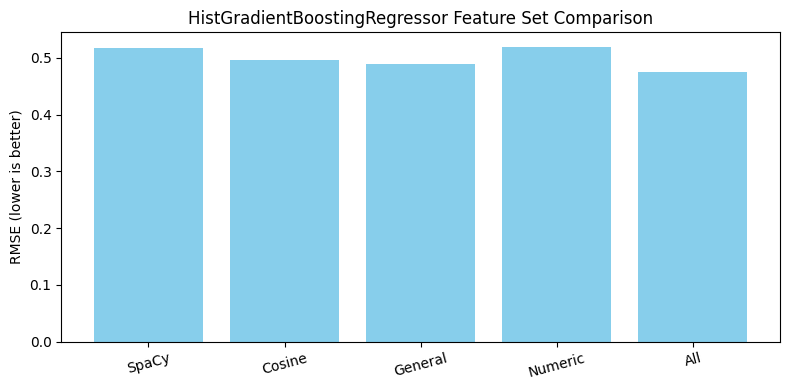

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# --- Define your feature groups ---
spacy_features = [col for col in df_complete.columns if col.startswith('spacy_sim_')]
cosine_features = ['cosine_title', 'cosine_description', 'cosine_bullets']
general_features = ['norm_overlap_title', 'word_in_title', 'brand_match', 'length_diff']
numeric_features = [f"{attr}_num" for attr in num_attrs] + ['len_of_query']

feature_sets = {
    "SpaCy": spacy_features,
    "Cosine": cosine_features,
    "General": general_features,
    "Numeric": numeric_features,
    "All": spacy_features + cosine_features + general_features + numeric_features
}

# --- Reuse train/test indices and target ---
train_idx = train.index
test_idx = test.index
y = df_complete['relevance']
results = {}

# --- Define training/evaluation function ---
def train_and_evaluate(X_train, y_train, X_test, y_test, label):
    model = HistGradientBoostingRegressor(max_iter=300, learning_rate=0.1, max_depth=6, random_state=42)
    model.fit(X_train.fillna(0), y_train)
    preds = model.predict(X_test.fillna(0))
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    results[label] = rmse
    print(f"{label}: RMSE = {rmse:.4f}")
    return model, preds

# --- Evaluate each feature set ---
for label, features in feature_sets.items():
    if not all(f in df_complete.columns for f in features):
        print(f"Skipping {label} (missing columns)")
        continue

    X_train = df_complete.loc[train_idx, features]
    y_train = y.loc[train_idx].values
    X_test = df_complete.loc[test_idx, features]
    y_test = y.loc[test_idx].values

    train_and_evaluate(X_train, y_train, X_test, y_test, label)

# --- Visualize results ---
plt.figure(figsize=(8, 4))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.ylabel("RMSE (lower is better)")
plt.title("HistGradientBoostingRegressor Feature Set Comparison")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
